In [1]:
import matplotlib.pyplot as plt
import numpy as np

# DATOS

In [2]:
from data_ibex35_yahoo import get_h_price

In [3]:
ibex_data = get_h_price()

[*********************100%***********************]  34 of 34 completed


3 Failed downloads:
['BKIA.MC', 'REE.MC', 'SGRE.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')


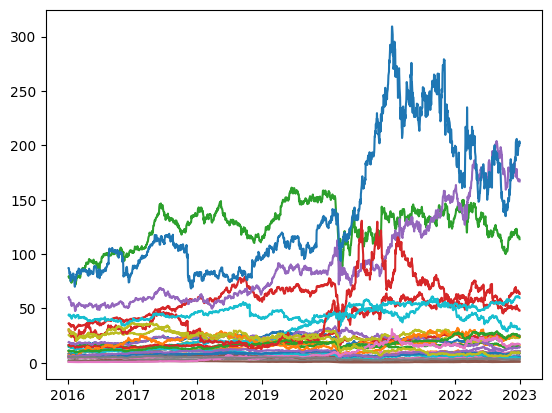

In [4]:
plt.plot(ibex_data);

# X e Y

In [5]:
from market_aux import h_price_to_data

In [6]:
X, Y = h_price_to_data(ibex_data)
X.shape, Y.shape

c:\Users\Julian\Documents\RepositoriosPersonales\GPU_venv\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


((1647, 149, 31), (1647, 31))

## Normalizamos la Y

In [7]:
r_min = np.min(Y, axis=1)[:, np.newaxis]
r_max = np.max(Y, axis=1)[:, np.newaxis]
r_min[-1], r_max[-1]

(array([0], dtype=int64), array([30], dtype=int64))

In [8]:
Y_NORM = 2 * (Y - 0) / (30 - 0) - 1

# TRAIN & VALID & TEST

In [9]:
X_TRAIN = X[:800]
Y_TRAIN = Y_NORM[:800]

X_VALID = X[800:1000]
Y_VALID = Y_NORM[800:1000]

X_TEST = X[1000:]
Y_TEST = Y_NORM[1000:]

# 1º Iteracion 
- Comparamos ambas redes con todos los datos
- Comparamos la media del ratio de sharpe calculado con los activos seleccionados en un dato.


# Red Neuronal

In [10]:
from my_models import gru_simple_v1_model

In [11]:
RN_model = gru_simple_v1_model(X, Y_NORM)

In [12]:
RN_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 149, 31)]         0         
                                                                 
 gru (GRU)                   (None, 1)                 102       
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
 flatten (Flatten)           (None, 1)                 0         
                                                                 
 dense_1 (Dense)             (None, 31)                62        
                                                                 
Total params: 166
Trainable params: 166
Non-trainable params:

In [13]:
h = RN_model.fit(X_TRAIN,Y_TRAIN,
          epochs=400,
          batch_size=X.shape[0],
          validation_data = (X_VALID, Y_VALID),
          verbose = False
          )

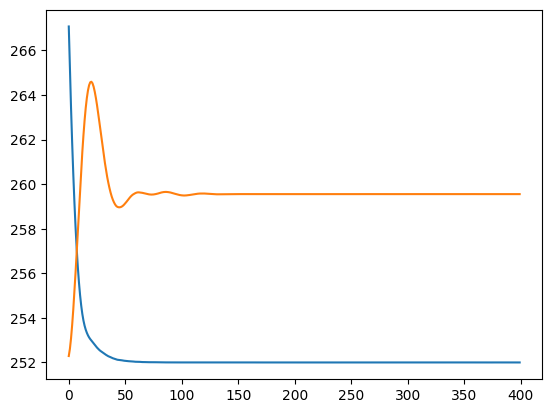

In [14]:
plt.plot(h.history["loss"])
plt.plot(h.history["val_loss"])

# Evolutivo

In [15]:
from evo import GeneticAlgorithm
from evo import I1_simple_gru
import timeit

In [16]:
i1 = I1_simple_gru()

In [17]:
population_size = 10
n_generations = 3
n_save_best_population = 3
n_inds_selection_function = 6
epochs=2
initial_population = i1.initial_population(population_size)

# assuming that X and Y are your data
ga = GeneticAlgorithm(
    initial_population=initial_population,
    fitness_function=lambda population: i1.fitness_function(population, X_TRAIN, Y_TRAIN, X_VALID, Y_VALID, epochs=epochs),
    selection_function=lambda population, fitness: i1.selection_function(population, fitness, n_inds_selection_function),
    crossover_function= i1.crossover_function,
    mutation_function=lambda population:  population,
    immigration_function=lambda: i1.initial_population(population_size),
    n_generations=n_generations,
    n_save_best_population=n_save_best_population
)

0


El tiempo de ejecución fue: 529.0011741 segundos


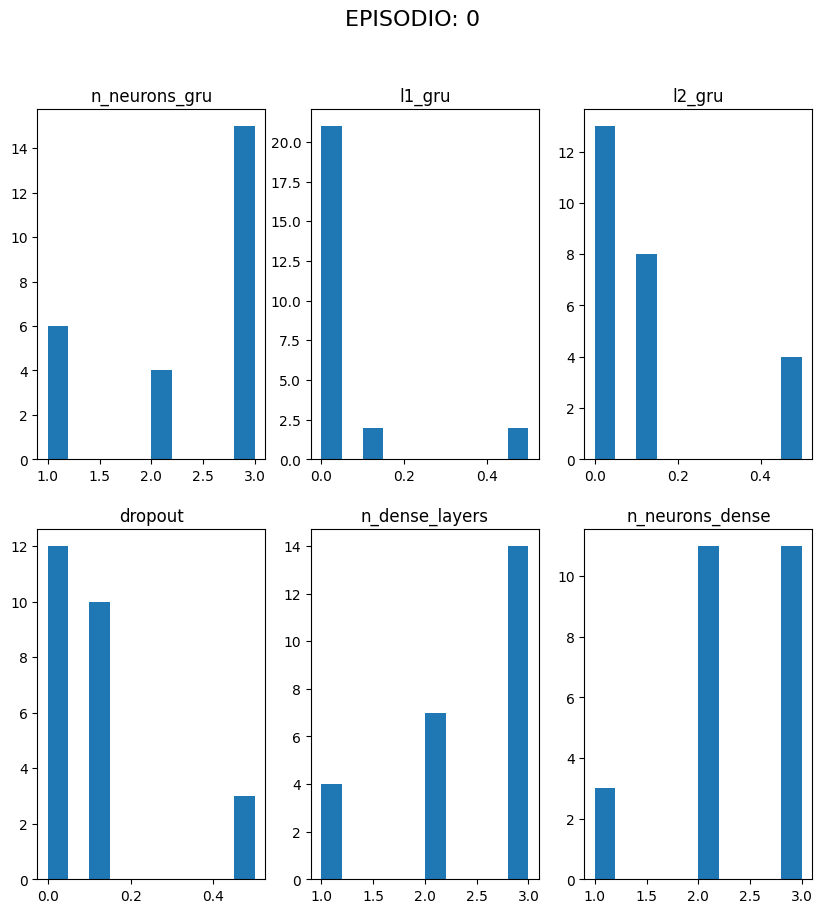

1
El tiempo de ejecución fue: 620.9987293 segundos


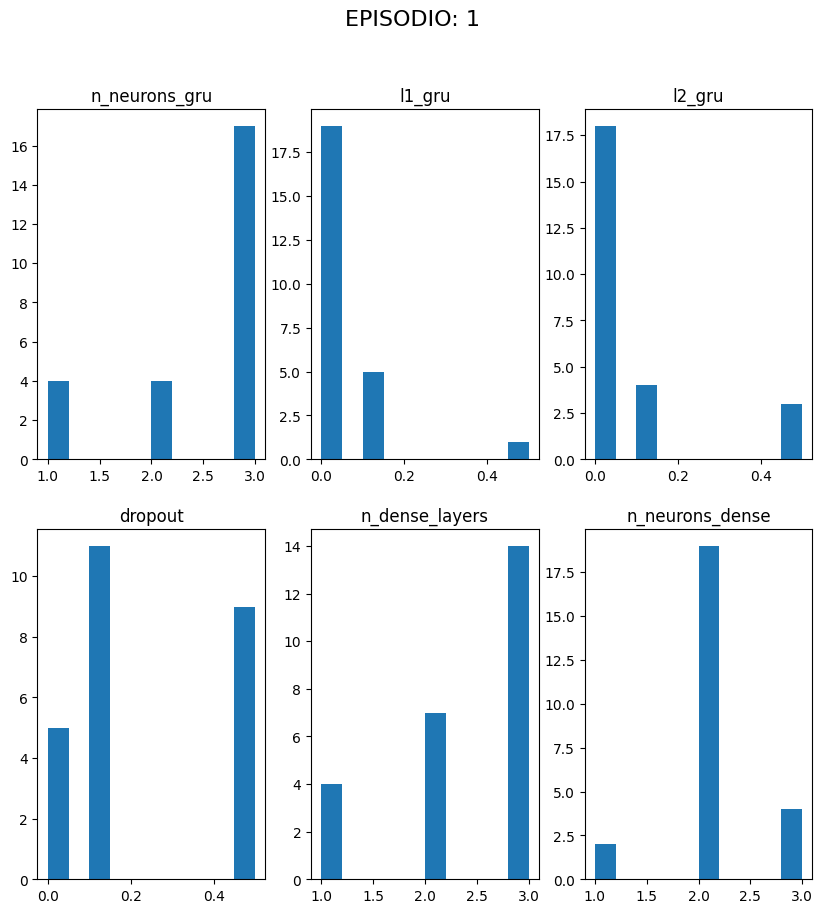

2
El tiempo de ejecución fue: 624.4141303000001 segundos


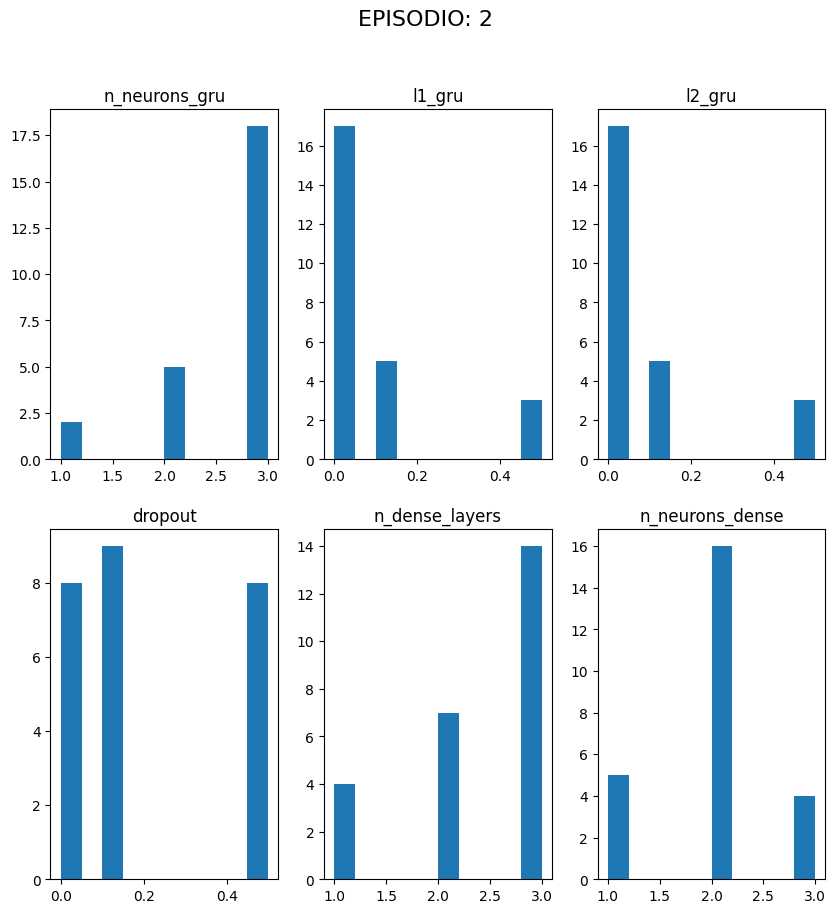

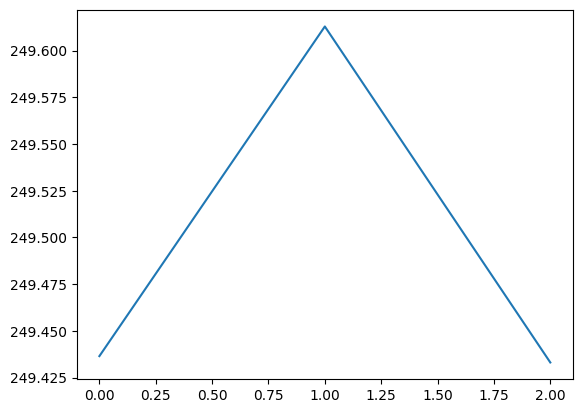

In [18]:
n_episodios = 3


fitness_evo = []

for i in range(n_episodios):
    print(i)
    start_time = timeit.default_timer()
    # ENTRENAMOS N GENERACIONES
    best_solution = ga.run()

    fitness_evo.append(ga.fitness.min())

    end_time = timeit.default_timer()
    execution_time = end_time - start_time
    print(f"El tiempo de ejecución fue: {execution_time} segundos")

    fig , axs = plt.subplots(2,3, figsize=(10,10))

    axs[0,0].hist(ga.population[:,0])
    axs[0,0].set_title('n_neurons_gru')

    axs[0,1].hist(ga.population[:,1])
    axs[0,1].set_title('l1_gru')

    axs[0,2].hist(ga.population[:,2])
    axs[0,2].set_title('l2_gru')

    axs[1,0].hist(ga.population[:,3])
    axs[1,0].set_title('dropout')

    axs[1,1].hist(ga.population[:,4])
    axs[1,1].set_title('n_dense_layers')

    axs[1,2].hist(ga.population[:,5])
    axs[1,2].set_title('n_neurons_dense')



    fig.suptitle('EPISODIO: ' + str(i), fontsize=16)


    plt.show()


plt.plot(fitness_evo)

# RN vs EVO